# Convert Raw Accelerometer Data to Minutely Step Counts (Forest Package)

This notebook uses the **official forest package** (cloned from GitHub) to compute step counts
from raw accelerometer data at minutely granularity.

This allows comparison with results from `05_convert_to_steps.ipynb` which uses the ported version.

## Forest Repository
- Source: https://github.com/onnela-lab/forest
- Location: `/n/home01/egraff/forest/`


In [14]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


## Configure Paths and Participants


In [18]:
# Configure paths
STUDY_FOLDER = '/n/home01/egraff/sample_imputation/data/raw'
OUTPUT_FOLDER = '/n/home01/egraff/sample_imputation/data/interim/forest_oak'
TZ_STR = 'America/New_York'

# Get participant IDs (excluding __MACOSX)
users = sorted([
    d.name for d in Path(STUDY_FOLDER).iterdir()
    if d.is_dir() and d.name != '__MACOSX'
])

print(f"Study folder: {STUDY_FOLDER}")
print(f"Output folder: {OUTPUT_FOLDER}")
print(f"Timezone: {TZ_STR}")
print(f"Found {len(users)} participants: {', '.join(users)}")


Study folder: /n/home01/egraff/sample_imputation/data/raw
Output folder: /n/home01/egraff/sample_imputation/data/interim/forest_oak
Timezone: America/New_York
Found 6 participants: 3si9xdvl, bn4j8yj9, gq36edfi, ubrmuu2r, xwyd72l9, zg5uqa5l


## Load Results

Load step count results from both implementations for comparison


### Load Forest (Official) Minutely Results


In [19]:
# Load forest (official) minutely results
FOREST_MINUTE_DIR = Path('/n/home01/egraff/sample_imputation/data/interim/forest_oak/minute')

forest_results: dict[str, pd.DataFrame] = {}

for user in users:
    forest_file = FOREST_MINUTE_DIR / f'{user}_gait_minutely.csv'
    
    if forest_file.exists():
        df = pd.read_csv(forest_file)
        # Rename 'date' column to 'timestamp' for consistency
        df = df.rename(columns={'date': 'timestamp'})
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        forest_results[user] = df
        print(f"Loaded forest results for {user}: {len(df):,} epochs")
    else:
        print(f"Warning: Forest output not found for {user}: {forest_file}")

print(f"\nLoaded forest results for {len(forest_results)} participants.")


Loaded forest results for 3si9xdvl: 11,520 epochs
Loaded forest results for bn4j8yj9: 11,520 epochs
Loaded forest results for gq36edfi: 11,520 epochs
Loaded forest results for ubrmuu2r: 11,520 epochs
Loaded forest results for xwyd72l9: 12,960 epochs
Loaded forest results for zg5uqa5l: 11,520 epochs

Loaded forest results for 6 participants.


### Load Ported Version Results


In [20]:
# Load ported version results
PORTED_OUTPUT_DIR = Path('/n/home01/egraff/sample_imputation/data/interim')

ported_results: dict[str, pd.DataFrame] = {}

for user in users:
    ported_file = PORTED_OUTPUT_DIR / f'{user}_steps.csv'
    
    if ported_file.exists():
        df = pd.read_csv(ported_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        ported_results[user] = df
        print(f"Loaded ported results for {user}: {len(df):,} epochs")
    else:
        print(f"Warning: Ported output not found for {user}: {ported_file}")
        print(f"  (Run 05_convert_to_steps.ipynb first)")

print(f"\nLoaded ported results for {len(ported_results)} participants.")


Loaded ported results for 3si9xdvl: 9,581 epochs


Loaded ported results for bn4j8yj9: 10,811 epochs
Loaded ported results for gq36edfi: 9,917 epochs
Loaded ported results for ubrmuu2r: 10,903 epochs
Loaded ported results for xwyd72l9: 11,580 epochs
Loaded ported results for zg5uqa5l: 10,154 epochs

Loaded ported results for 6 participants.


## Compare Forest vs Ported Results


In [21]:
def compare_results(user: str, forest_df: pd.DataFrame, ported_df: pd.DataFrame) -> pd.DataFrame:
    """Merge and compare forest vs ported results for a user."""
    
    # Standardize timestamp formats for merging
    forest_df = forest_df.copy()
    ported_df = ported_df.copy()
    
    # Remove timezone info for comparison (if present)
    if forest_df['timestamp'].dt.tz is not None:
        forest_df['timestamp'] = forest_df['timestamp'].dt.tz_localize(None)
    if ported_df['timestamp'].dt.tz is not None:
        ported_df['timestamp'] = ported_df['timestamp'].dt.tz_localize(None)
    
    # Floor to minute to ensure alignment
    forest_df['timestamp'] = forest_df['timestamp'].dt.floor('T')
    ported_df['timestamp'] = ported_df['timestamp'].dt.floor('T')
    
    # Merge on timestamp
    merged = forest_df.merge(
        ported_df,
        on='timestamp',
        how='outer',
        suffixes=('_forest', '_ported')
    ).sort_values('timestamp')
    
    return merged


# Compare results for all participants with both datasets
comparison_results: dict[str, pd.DataFrame] = {}

for user in users:
    if user in forest_results and user in ported_results:
        merged = compare_results(user, forest_results[user], ported_results[user])
        comparison_results[user] = merged
        print(f"{user}: {len(merged):,} total epochs after merge")
    else:
        print(f"{user}: Missing data (forest: {user in forest_results}, ported: {user in ported_results})")


/tmp/ipykernel_640227/1308973089.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forest_df['timestamp'] = forest_df['timestamp'].dt.floor('T')
/tmp/ipykernel_640227/1308973089.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ported_df['timestamp'] = ported_df['timestamp'].dt.floor('T')
/tmp/ipykernel_640227/1308973089.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forest_df['timestamp'] = forest_df['timestamp'].dt.floor('T')
/tmp/ipykernel_640227/1308973089.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ported_df['timestamp'] = ported_df['timestamp'].dt.floor('T')
/tmp/ipykernel_640227/1308973089.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forest_df['timestamp'] = forest_df['timest

3si9xdvl: 11,520 total epochs after merge
bn4j8yj9: 11,520 total epochs after merge
gq36edfi: 11,520 total epochs after merge
ubrmuu2r: 11,520 total epochs after merge
xwyd72l9: 12,960 total epochs after merge
zg5uqa5l: 11,520 total epochs after merge


## Compute Comparison Statistics


In [22]:
from scipy import stats

def compute_comparison_stats(merged_df: pd.DataFrame, 
                             hourly_forest_df: pd.DataFrame = None,
                             hourly_ported_df: pd.DataFrame = None,
                             daily_forest_df: pd.DataFrame = None,
                             daily_ported_df: pd.DataFrame = None) -> dict:
    """Compute comparison statistics between forest and ported results at multiple temporal resolutions."""
    
    # Get matched rows for minutely data (both have step data)
    matched = merged_df.dropna(subset=['steps_forest', 'steps_ported'])
    
    if len(matched) == 0:
        return {'n_matched': 0}
    
    forest_steps = matched['steps_forest'].values
    ported_steps = matched['steps_ported'].values
    
    # Minutely Correlation
    if len(matched) > 1:
        corr_minute, p_value_minute = stats.pearsonr(forest_steps, ported_steps)
    else:
        corr_minute, p_value_minute = np.nan, np.nan
    
    # Hourly Correlation
    corr_hourly, p_value_hourly = np.nan, np.nan
    if hourly_forest_df is not None and hourly_ported_df is not None:
        # Merge hourly data
        hourly_merged = hourly_forest_df.merge(
            hourly_ported_df,
            on='timestamp',
            how='inner',
            suffixes=('_forest', '_ported')
        )
        hourly_matched = hourly_merged.dropna(subset=['steps_forest', 'steps_ported'])
        if len(hourly_matched) > 1:
            corr_hourly, p_value_hourly = stats.pearsonr(
                hourly_matched['steps_forest'].values,
                hourly_matched['steps_ported'].values
            )
    
    # Daily Correlation
    corr_daily, p_value_daily = np.nan, np.nan
    if daily_forest_df is not None and daily_ported_df is not None:
        # Merge daily data
        daily_merged = daily_forest_df.merge(
            daily_ported_df,
            on='date',
            how='inner',
            suffixes=('_forest', '_ported')
        )
        daily_matched = daily_merged.dropna(subset=['steps_forest', 'steps_ported'])
        if len(daily_matched) > 1:
            corr_daily, p_value_daily = stats.pearsonr(
                daily_matched['steps_forest'].values,
                daily_matched['steps_ported'].values
            )
    
    # Error metrics (minutely)
    diff = forest_steps - ported_steps
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    
    # Total steps
    total_forest = forest_steps.sum()
    total_ported = ported_steps.sum()
    
    return {
        'n_matched': len(matched),
        'n_forest_only': merged_df['steps_forest'].notna().sum() - len(matched),
        'n_ported_only': merged_df['steps_ported'].notna().sum() - len(matched),
        'correlation_minute': corr_minute,
        'correlation_hourly': corr_hourly,
        'correlation_daily': corr_daily,
        'p_value_minute': p_value_minute,
        'p_value_hourly': p_value_hourly,
        'p_value_daily': p_value_daily,
        'mae': mae,
        'rmse': rmse,
        'total_steps_forest': int(total_forest),
        'total_steps_ported': int(total_ported),
        'diff_pct': (total_forest - total_ported) / total_ported * 100 if total_ported > 0 else np.nan
    }


In [23]:
# Load forest hourly and daily data
FOREST_OUTPUT_DIR = Path('/n/home01/egraff/sample_imputation/data/interim/forest_oak')

forest_hourly: dict[str, pd.DataFrame] = {}
forest_daily: dict[str, pd.DataFrame] = {}

for user in users:
    # Load forest hourly
    hourly_file = FOREST_OUTPUT_DIR / f'{user}_steps_hourly.csv'
    if hourly_file.exists():
        df = pd.read_csv(hourly_file)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        if df['timestamp'].dt.tz is not None:
            df['timestamp'] = df['timestamp'].dt.tz_localize(None)
        forest_hourly[user] = df
    
    # Load forest daily
    daily_file = FOREST_OUTPUT_DIR / f'{user}_steps_daily.csv'
    if daily_file.exists():
        df = pd.read_csv(daily_file)
        df['date'] = pd.to_datetime(df['date']).dt.date
        forest_daily[user] = df

print(f"Loaded forest hourly data for {len(forest_hourly)} participants")
print(f"Loaded forest daily data for {len(forest_daily)} participants")


Loaded forest hourly data for 6 participants
Loaded forest daily data for 6 participants


In [24]:
# Aggregate ported minutely data to hourly and daily
ported_hourly: dict[str, pd.DataFrame] = {}
ported_daily: dict[str, pd.DataFrame] = {}

for user, df in ported_results.items():
    df = df.copy()
    
    # Remove timezone for consistency
    if df['timestamp'].dt.tz is not None:
        df['timestamp'] = df['timestamp'].dt.tz_localize(None)
    
    # Aggregate to hourly
    df['hour'] = df['timestamp'].dt.floor('h')
    hourly = df.groupby('hour').agg(
        steps=('steps', 'sum'),
        walking_time=('walking_time', 'sum')
    ).reset_index()
    hourly = hourly.rename(columns={'hour': 'timestamp'})
    # Compute cadence for hourly (avoid division by zero)
    hourly['cadence'] = np.where(
        hourly['walking_time'] > 0,
        hourly['steps'] / hourly['walking_time'],
        np.nan
    )
    ported_hourly[user] = hourly
    
    # Aggregate to daily
    df['date'] = df['timestamp'].dt.date
    daily = df.groupby('date').agg(
        steps=('steps', 'sum'),
        walking_time=('walking_time', 'sum')
    ).reset_index()
    daily['cadence'] = np.where(
        daily['walking_time'] > 0,
        daily['steps'] / daily['walking_time'],
        np.nan
    )
    ported_daily[user] = daily

print(f"Aggregated ported data to hourly for {len(ported_hourly)} participants")
print(f"Aggregated ported data to daily for {len(ported_daily)} participants")


Aggregated ported data to hourly for 6 participants
Aggregated ported data to daily for 6 participants


In [25]:
# Compute stats for all participants with hourly and daily correlations
all_stats = []
for user, merged_df in comparison_results.items():
    # Get hourly and daily data for this user
    hourly_forest = forest_hourly.get(user)
    hourly_ported = ported_hourly.get(user)
    daily_forest = forest_daily.get(user)
    daily_ported = ported_daily.get(user)
    
    user_stats = compute_comparison_stats(
        merged_df,
        hourly_forest_df=hourly_forest,
        hourly_ported_df=hourly_ported,
        daily_forest_df=daily_forest,
        daily_ported_df=daily_ported
    )
    user_stats['user'] = user
    all_stats.append(user_stats)

stats_df = pd.DataFrame(all_stats)

print("Comparison Statistics (Forest vs Ported):")
print("=" * 100)
print(stats_df[['user', 'n_matched', 'correlation_minute', 'correlation_hourly', 
                'correlation_daily', 'mae', 'rmse', 'total_steps_forest', 
                'total_steps_ported', 'diff_pct']].to_string(index=False))


Comparison Statistics (Forest vs Ported):
    user  n_matched  correlation_minute  correlation_hourly  correlation_daily      mae      rmse  total_steps_forest  total_steps_ported  diff_pct
3si9xdvl       6284            0.118155            0.211895           0.985717 2.949554 12.211176               10355               10406 -0.490102
bn4j8yj9      10391           -0.015013           -0.052883           0.992835 2.250120 12.021974               12096               11427  5.854555
gq36edfi       9255            0.012470            0.056407           0.999174 2.256294  9.430550               12627                9113 38.560298
ubrmuu2r      10634            0.010555            0.024272           0.994731 2.789825 12.395476               15151               15710 -3.558243
xwyd72l9      11340           -0.007974           -0.036703           0.998628 1.811905  9.159410               10519               10264  2.484412
zg5uqa5l       9855           -0.008786           -0.078046           

## Correlation Heatmaps (Minutely, Hourly, Daily)


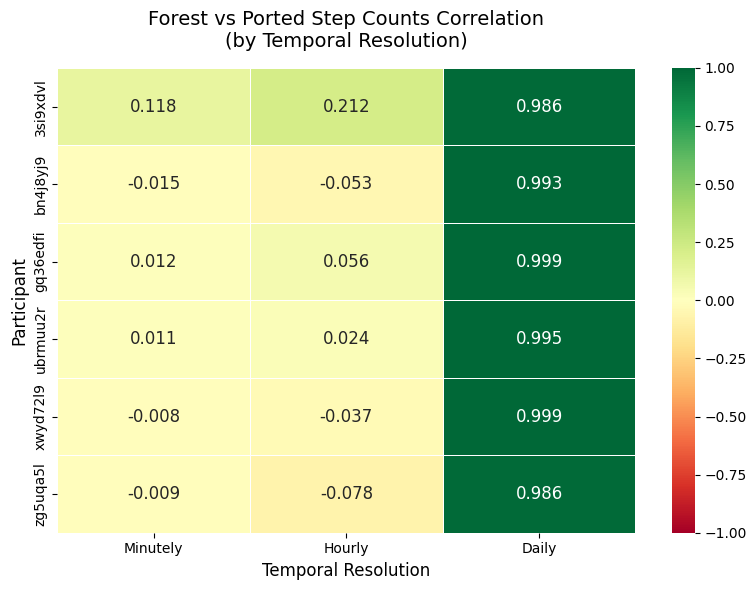


Correlation Summary:
Minutely - Mean: 0.0182, Std: 0.0502
Hourly   - Mean: 0.0208, Std: 0.1061
Daily    - Mean: 0.9929, Std: 0.0058


In [26]:
import seaborn as sns

# Create correlation heatmap data
corr_data = stats_df[['user', 'correlation_minute', 'correlation_hourly', 'correlation_daily']].copy()
corr_data = corr_data.rename(columns={
    'correlation_minute': 'Minutely',
    'correlation_hourly': 'Hourly',
    'correlation_daily': 'Daily'
})
corr_data = corr_data.set_index('user')

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    corr_data,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    ax=ax,
    annot_kws={'size': 12}
)

ax.set_title('Forest vs Ported Step Counts Correlation\n(by Temporal Resolution)', fontsize=14, pad=15)
ax.set_xlabel('Temporal Resolution', fontsize=12)
ax.set_ylabel('Participant', fontsize=12)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nCorrelation Summary:")
print("=" * 60)
print(f"Minutely - Mean: {corr_data['Minutely'].mean():.4f}, Std: {corr_data['Minutely'].std():.4f}")
print(f"Hourly   - Mean: {corr_data['Hourly'].mean():.4f}, Std: {corr_data['Hourly'].std():.4f}")
print(f"Daily    - Mean: {corr_data['Daily'].mean():.4f}, Std: {corr_data['Daily'].std():.4f}")


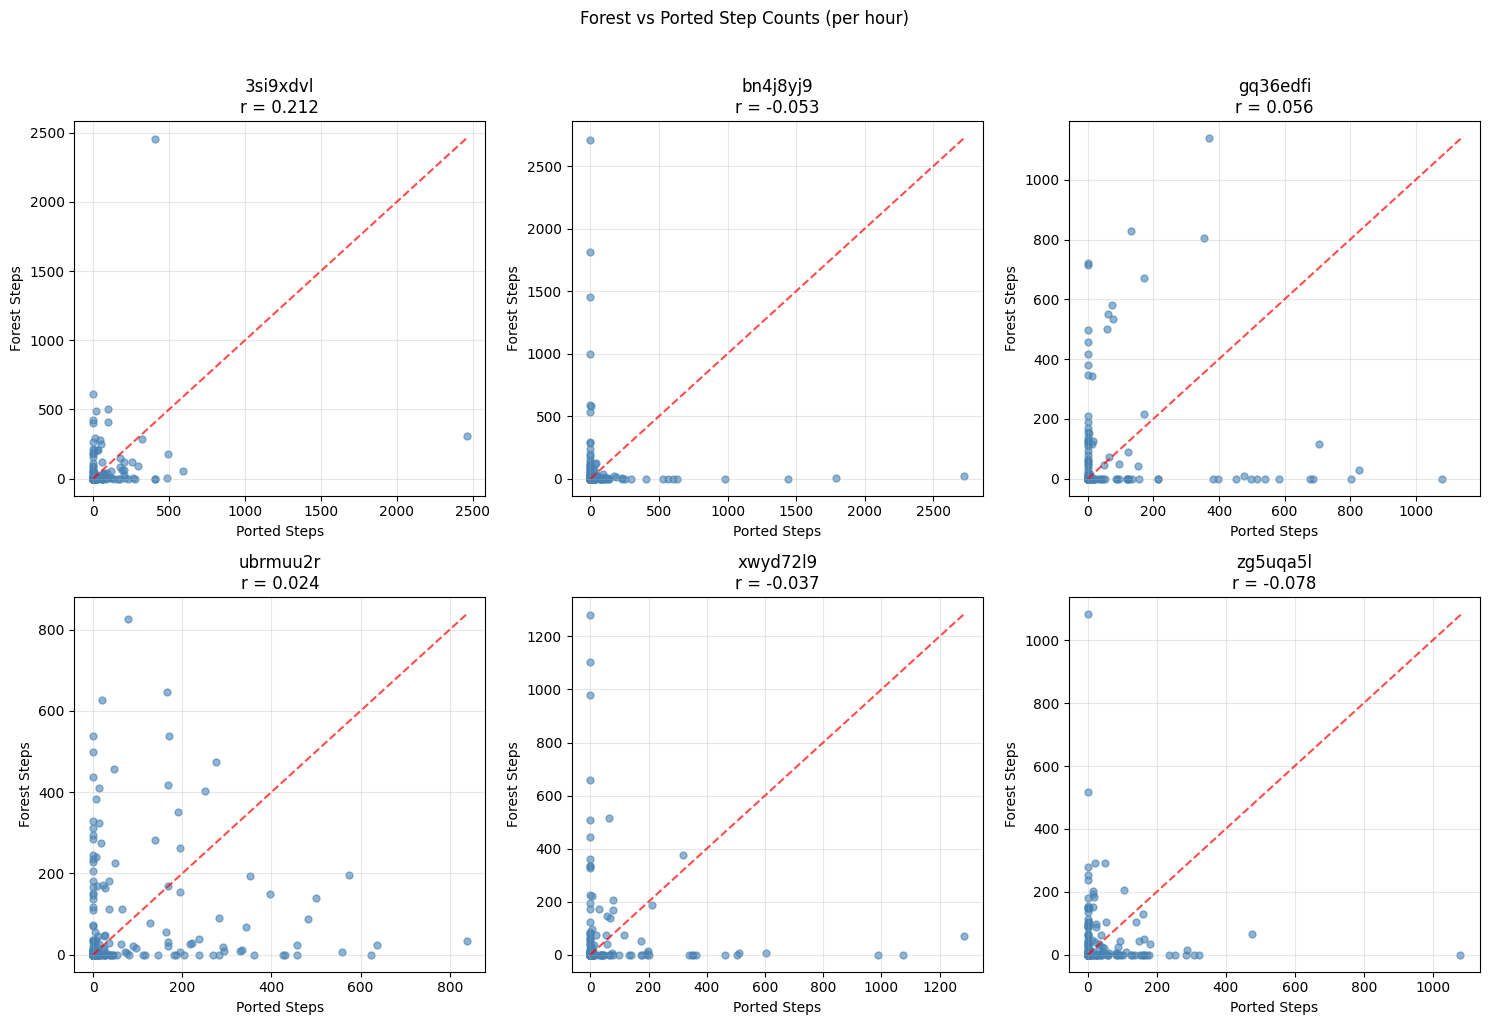

In [27]:
# Create scatter plots for hourly step counts
n_users = len(comparison_results)
if n_users > 0 and len(forest_hourly) > 0 and len(ported_hourly) > 0:
    n_cols = min(3, n_users)
    n_rows = (n_users + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_users == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, user in enumerate(users):
        ax = axes[idx]
        
        if user in forest_hourly and user in ported_hourly:
            # Merge hourly data
            hourly_merged = forest_hourly[user].merge(
                ported_hourly[user],
                on='timestamp',
                how='inner',
                suffixes=('_forest', '_ported')
            )
            matched = hourly_merged.dropna(subset=['steps_forest', 'steps_ported'])
            
            if len(matched) > 0:
                ax.scatter(matched['steps_ported'], matched['steps_forest'], 
                          alpha=0.6, s=25, color='steelblue')
                
                # Add identity line
                max_val = max(matched['steps_ported'].max(), matched['steps_forest'].max())
                ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='y=x')
                
                # Add correlation to title
                corr = stats_df[stats_df['user'] == user]['correlation_hourly'].values[0]
                ax.set_title(f'{user}\nr = {corr:.3f}')
            else:
                ax.set_title(f'{user}\nNo matched data')
        else:
            ax.set_title(f'{user}\nNo data')
        
        ax.set_xlabel('Ported Steps')
        ax.set_ylabel('Forest Steps')
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_users, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Forest vs Ported Step Counts (per hour)', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No hourly comparison data available.")


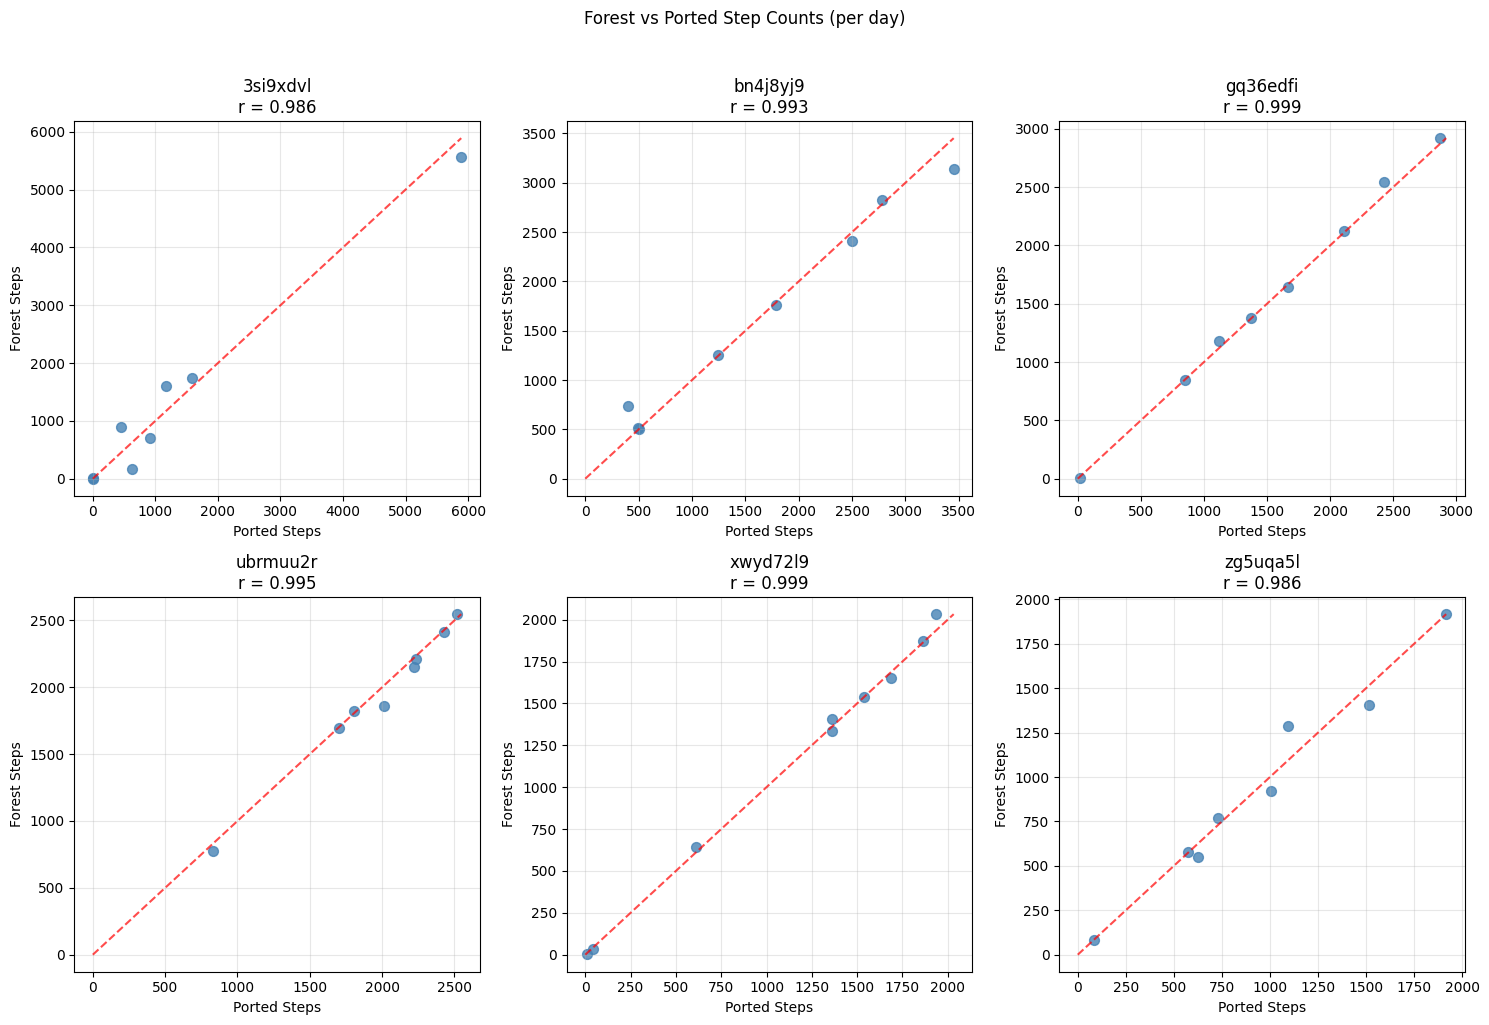

In [28]:
# Create scatter plots for daily step counts
n_users = len(comparison_results)
if n_users > 0 and len(forest_daily) > 0 and len(ported_daily) > 0:
    n_cols = min(3, n_users)
    n_rows = (n_users + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_users == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, user in enumerate(users):
        ax = axes[idx]
        
        if user in forest_daily and user in ported_daily:
            # Merge daily data
            daily_merged = forest_daily[user].merge(
                ported_daily[user],
                on='date',
                how='inner',
                suffixes=('_forest', '_ported')
            )
            matched = daily_merged.dropna(subset=['steps_forest', 'steps_ported'])
            
            if len(matched) > 0:
                ax.scatter(matched['steps_ported'], matched['steps_forest'], 
                          alpha=0.8, s=50, color='steelblue')
                
                # Add identity line
                max_val = max(matched['steps_ported'].max(), matched['steps_forest'].max())
                ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='y=x')
                
                # Add correlation to title
                corr = stats_df[stats_df['user'] == user]['correlation_daily'].values[0]
                ax.set_title(f'{user}\nr = {corr:.3f}')
            else:
                ax.set_title(f'{user}\nNo matched data')
        else:
            ax.set_title(f'{user}\nNo data')
        
        ax.set_xlabel('Ported Steps')
        ax.set_ylabel('Forest Steps')
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_users, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Forest vs Ported Step Counts (per day)', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No daily comparison data available.")


## Scatter Plot: Forest vs Ported Step Counts


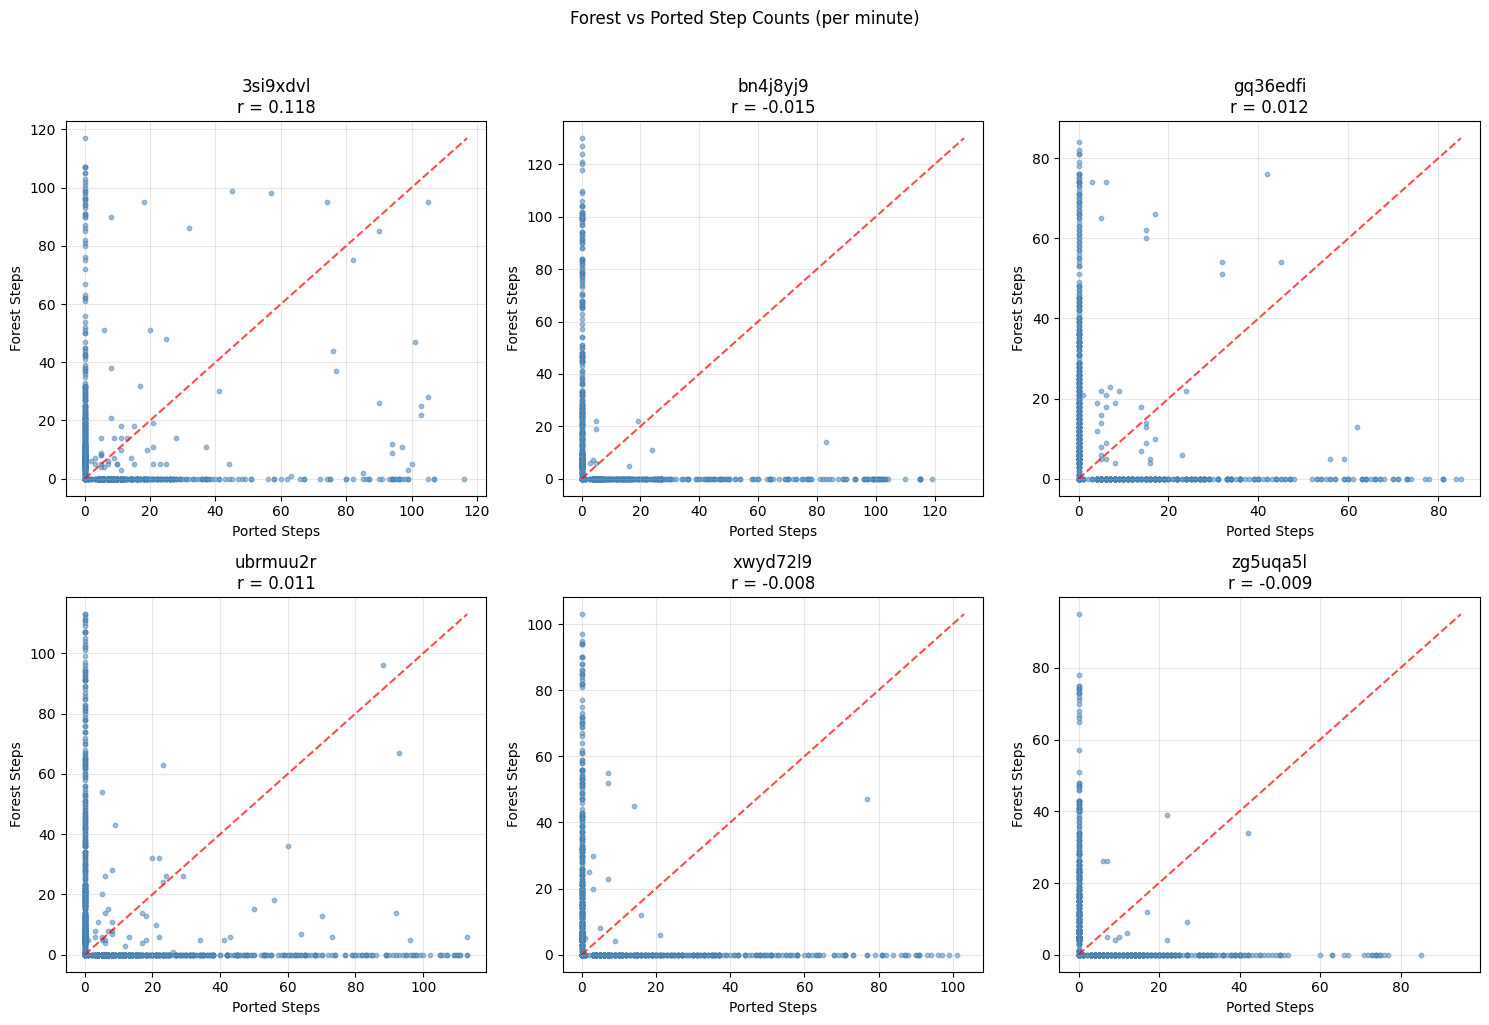

In [29]:
# Create scatter plots for each participant
n_users = len(comparison_results)
if n_users > 0:
    n_cols = min(3, n_users)
    n_rows = (n_users + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_users == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (user, merged_df) in enumerate(comparison_results.items()):
        ax = axes[idx]
        
        # Get matched data
        matched = merged_df.dropna(subset=['steps_forest', 'steps_ported'])
        
        if len(matched) > 0:
            ax.scatter(matched['steps_ported'], matched['steps_forest'], 
                      alpha=0.5, s=10, color='steelblue')
            
            # Add identity line
            max_val = max(matched['steps_ported'].max(), matched['steps_forest'].max())
            ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='y=x')
            
            # Add correlation to title
            corr = stats_df[stats_df['user'] == user]['correlation_minute'].values[0]
            ax.set_title(f'{user}\nr = {corr:.3f}')
        else:
            ax.set_title(f'{user}\nNo matched data')
        
        ax.set_xlabel('Ported Steps')
        ax.set_ylabel('Forest Steps')
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_users, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Forest vs Ported Step Counts (per minute)', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No comparison data available.")


## Time Series Comparison


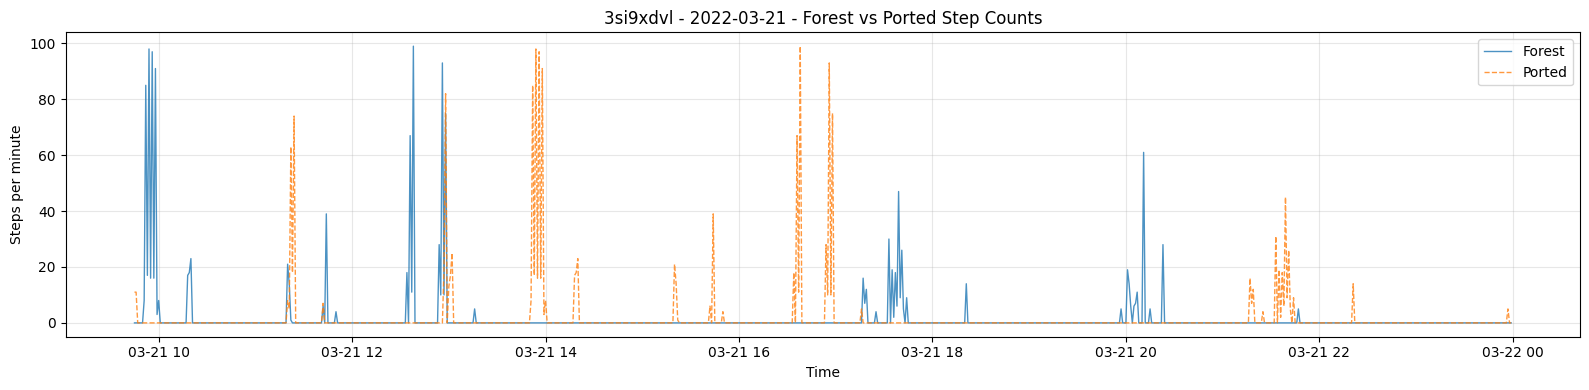

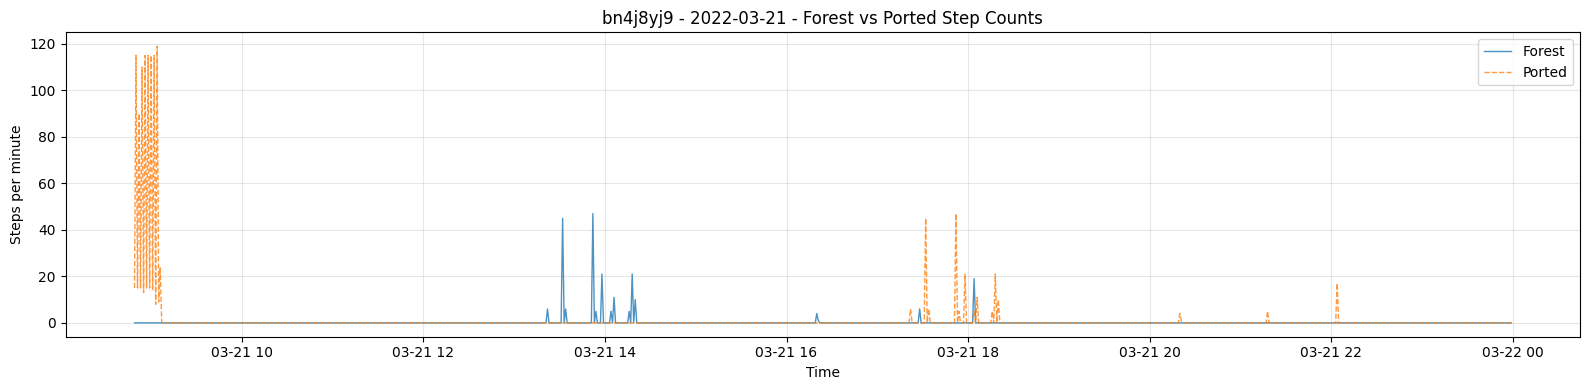

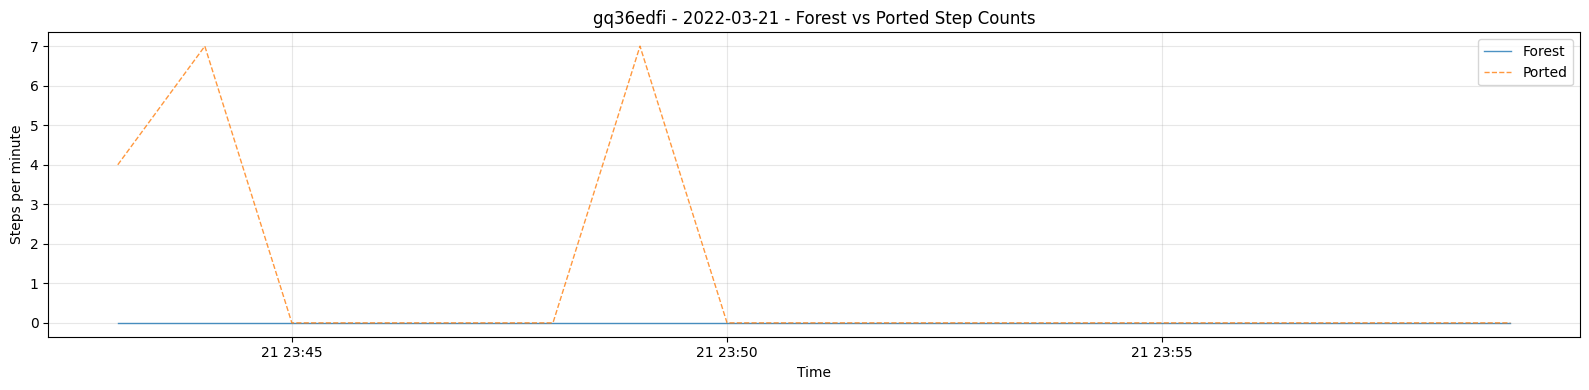

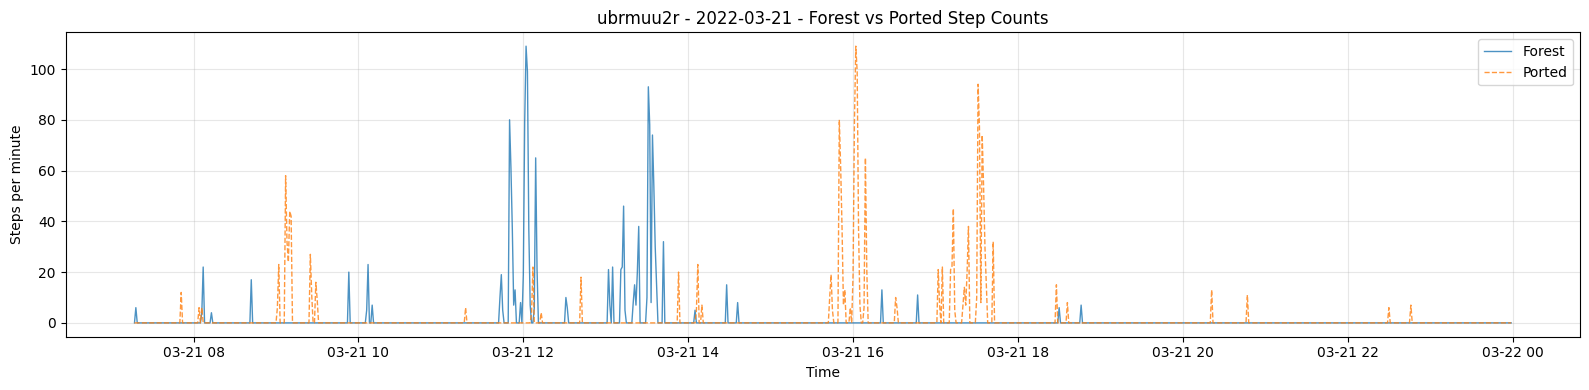

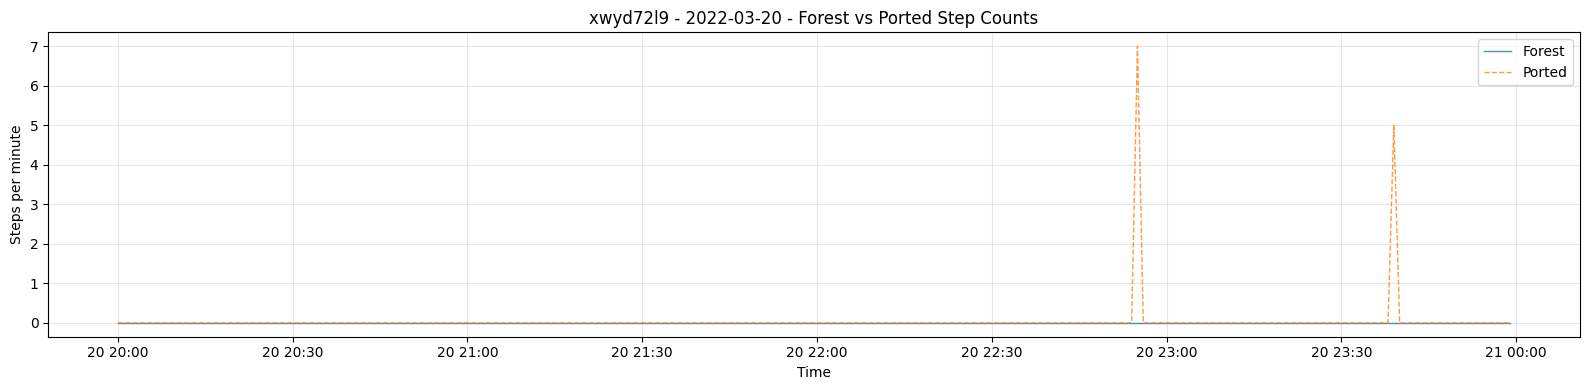

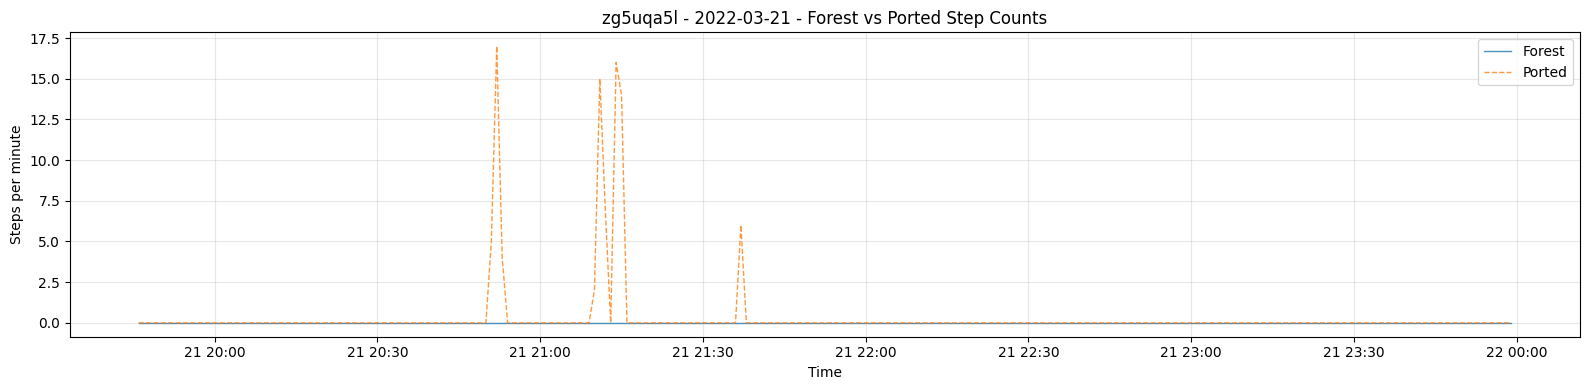

In [30]:
# Plot time series comparison for each participant (one day sample)
for user, merged_df in comparison_results.items():
    matched = merged_df.dropna(subset=['steps_forest', 'steps_ported']).copy()
    
    if len(matched) == 0:
        print(f"{user}: No matched data to plot")
        continue
    
    matched['date'] = matched['timestamp'].dt.date
    unique_dates = sorted(matched['date'].unique())
    
    # Plot first day with data
    if len(unique_dates) > 0:
        sample_date = unique_dates[0]
        day_data = matched[matched['date'] == sample_date]
        
        fig, ax = plt.subplots(figsize=(16, 4))
        
        ax.plot(day_data['timestamp'], day_data['steps_forest'], 
               label='Forest', alpha=0.8, linewidth=1)
        ax.plot(day_data['timestamp'], day_data['steps_ported'], 
               label='Ported', alpha=0.8, linewidth=1, linestyle='--')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Steps per minute')
        ax.set_title(f'{user} - {sample_date} - Forest vs Ported Step Counts')
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()


## Daily Totals Comparison


In [31]:
# Compare daily step totals
all_daily = []

for user, merged_df in comparison_results.items():
    merged_df = merged_df.copy()
    merged_df['date'] = merged_df['timestamp'].dt.date
    
    daily = merged_df.groupby('date').agg(
        steps_forest=('steps_forest', 'sum'),
        steps_ported=('steps_ported', 'sum')
    ).reset_index()
    
    daily['user'] = user
    all_daily.append(daily)

if all_daily:
    daily_df = pd.concat(all_daily, ignore_index=True)
    daily_df['diff'] = daily_df['steps_forest'] - daily_df['steps_ported']
    daily_df['diff_pct'] = daily_df['diff'] / daily_df['steps_ported'] * 100
    
    print("Daily Step Totals Comparison:")
    print("=" * 80)
    print(daily_df.to_string(index=False))
    
    # Summary
    print(f"\n\nOverall Summary:")
    print(f"  Mean daily difference: {daily_df['diff'].mean():.1f} steps")
    print(f"  Mean daily difference %: {daily_df['diff_pct'].mean():.1f}%")
else:
    print("No daily data available.")


Daily Step Totals Comparison:
      date  steps_forest  steps_ported     user   diff   diff_pct
2022-03-21        1744.0        1579.0 3si9xdvl  165.0  10.449652
2022-03-22         707.0         909.0 3si9xdvl -202.0 -22.222222
2022-03-23          19.0           4.0 3si9xdvl   15.0 375.000000
2022-03-24        1606.0        1172.0 3si9xdvl  434.0  37.030717
2022-03-25         891.0         444.0 3si9xdvl  447.0 100.675676
2022-03-26        5571.0        5890.0 3si9xdvl -319.0  -5.415959
2022-03-27         172.0         619.0 3si9xdvl -447.0 -72.213247
2022-03-28           0.0           0.0 3si9xdvl    0.0        NaN
2022-03-21        1251.0        1246.0 bn4j8yj9    5.0   0.401284
2022-03-22         512.0         493.0 bn4j8yj9   19.0   3.853955
2022-03-23        2405.0        2502.0 bn4j8yj9  -97.0  -3.876898
2022-03-24        2826.0        2782.0 bn4j8yj9   44.0   1.581596
2022-03-25         503.0         499.0 bn4j8yj9    4.0   0.801603
2022-03-26         737.0         398.0 bn4j8yj

## Summary

This notebook compared step counts computed by:
1. **Forest (official)**: `forest.oak.base.run()` from the cloned GitHub repository
2. **Ported version**: `src/steps/oak.py` from `05_convert_to_steps.ipynb`

### Key Metrics
- **Correlation (Minutely/Hourly/Daily)**: How well the two implementations agree at different temporal resolutions (1.0 = perfect)
- **MAE**: Mean Absolute Error (average difference in steps per minute)
- **RMSE**: Root Mean Square Error (penalizes larger differences)
- **diff_pct**: Percentage difference in total steps

### Temporal Resolution Analysis
The correlation heatmap shows how agreement between Forest and Ported implementations varies across:
- **Minutely**: Per-minute step counts (highest granularity)
- **Hourly**: Aggregated hourly step totals
- **Daily**: Aggregated daily step totals

Higher correlations at coarser temporal resolutions (hourly/daily) suggest that while minute-level predictions may differ, the implementations converge when aggregated over longer time periods.
